# 2023 CITS4012 Assignment

Max Chatfield 22176321

Nicholas Clarke 10417777

# 1.DataSet Processing

In [1]:
# when not using colab
import sys
sys.path.append('./src/QA')

In [1]:
# only need to run these commands if using Colab
# Mount google drive and change directory to the git repo folder
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/CITS4012_2023
import sys
# colab seems to require an explicit path for this to work from mounted drive
sys.path.append('/content/gdrive/MyDrive/CITS4012_2023/src/QA')

Mounted at /content/gdrive
/content/gdrive/MyDrive/CITS4012_2023


In [2]:
from data_prep import DataPrep
import model
from model.results_helpers import ResultsHelper

In [3]:
df = DataPrep.parse_tsv('WikiQA-train.tsv')
question_doc_raw_train = DataPrep.convert_pd_to_json(df)
df = DataPrep.parse_tsv('WikiQA-test.tsv')
question_doc_raw_test = DataPrep.convert_pd_to_json(df)

In [4]:
question_doc_raw_train["Q1"]

{'document': [('A partly submerged glacier cave on Perito Moreno Glacier .',
   0),
  ('The ice facade is approximately 60 m high', 0),
  ('Ice formations in the Titlis glacier cave', 0),
  ('A glacier cave is a cave formed within the ice of a glacier .', 1),
  ('Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.',
   0)],
 'question': 'how are glacier caves formed?'}

NER tagging, some initial testing of the function

Questions that NER tagging works in:
- how many series in hockey before the stanley cup
- how much are the harry potter movies worth

Questions it doesn't work in:
- how did anne frank die
- what did benedict arnold die
- how old is kurt cobain's daughter


In [5]:
from word_embed import WordEmbed

In [6]:
from feat_extract import FeatExt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/max/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/max/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from embed_doc import EmbedAndConcat

In [36]:
# returns a tuple with:
# 0 - question tokenized
# 1 - list of sentences tokenized
# 2 - list of corresponding sentence in-or-out tokens
q1_toks = DataPrep.tokenize_question_and_doc(question_doc_raw_train["Q1"])

In [37]:
# returns a list of embedded sentences, with each sentence having one array for each word
toks_embedded = EmbedAndConcat.doc_concat(q1_toks[1])

In [38]:
# same as above, but includes named entity recognition tags in the arrays
doc_ner_tags = FeatExt.ner_tag_doc(question_doc_raw_train["Q1"]["document"])
toks_embedded_with_ner = EmbedAndConcat.doc_concat(q1_toks[1], with_ner=True, doc_ner_tags=doc_ner_tags)

In [39]:
# these functions do the same, but for questions
q_embedded = EmbedAndConcat.q_concat(q1_toks[0])

In [40]:
q_ner_tags = FeatExt.ner_tag(question_doc_raw_train["Q1"]["question"])
q_embedded_with_ner = EmbedAndConcat.q_concat(q1_toks[0], with_ner=True, question_ner_tags=q_ner_tags)

# 2.QA Model Implementation

In [71]:
# the model we ended up using is in the python file src/QA/model/QA_RNN.py
# it is pasted here for examination
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

cos = nn.CosineSimilarity(dim=2)

# QA with document RNN model
# use attention between the question and document.
class DocumentModel(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    ATTN_TYPE_SCALED_DOT_PRODUCT = "Scaled Dot Product"
    ATTN_TYPE_COSINE = "Cosine"

    HIDDEN_TYPE_RNN = "RNN"
    HIDDEN_TYPE_LSTM = "LSTM"
    HIDDEN_TYPE_GRU = "GRU"

    def __init__(self, n_input, n_hidden, n_class, attention_type=ATTN_TYPE_DOT_PRODUCT, hidden_layers=1, hidden_layer=HIDDEN_TYPE_RNN, bidirectional=True):
        super(DocumentModel, self).__init__()

        self.attention_type = attention_type
        if hidden_layer == DocumentModel.HIDDEN_TYPE_LSTM:
            self.rnn = nn.LSTM(n_input, n_hidden, hidden_layers, batch_first=True, bidirectional=bidirectional)
        elif hidden_layer == DocumentModel.HIDDEN_TYPE_GRU:
            self.rnn = nn.GRU(n_input, n_hidden, hidden_layers, batch_fitst=True, bidirectional=bidirectional)
        else: # vanilla RNN
            self.rnn = nn.RNN(n_input, n_hidden, hidden_layers, batch_first=True, bidirectional=bidirectional)

        linear_layer_size = n_hidden
        if bidirectional:
            linear_layer_size = 2*linear_layer_size
        self.out = nn.Linear(linear_layer_size, n_class)

    def calc_attention(self, hidden, question_hidden, method):
        if method == DocumentModel.ATTN_TYPE_DOT_PRODUCT:
            weights =  F.softmax(torch.bmm(hidden, question_hidden.transpose(1,2)), dim=-1)
            attention_output = torch.bmm(weights, question_hidden)
        elif method == DocumentModel.ATTN_TYPE_SCALED_DOT_PRODUCT:
            weights = F.softmax(torch.bmm(hidden, question_hidden.transpose(1,2))/np.sqrt(hidden.shape[2]), dim=-1)
            attention_output = torch.bmm(weights, question_hidden)
        elif method == DocumentModel.ATTN_TYPE_COSINE:
            weights = F.softmax(cos(hidden, question_hidden.transpose(1,2)), dim=-1)
            attention_output = torch.bmm(weights, question_hidden)
        return attention_output

    def forward(self, input, question_hidden):        
        rnn_output, _ = self.rnn(input) 

        attention_output = self.calc_attention(rnn_output, question_hidden, self.attention_type)

        # log softmax as we use a negative log likelihood loss
        output = F.log_softmax(self.out(attention_output), dim=-1)
        return output

class QuestionModel(nn.Module):
    def __init__(self, n_input, n_hidden, hidden_layers=1, hidden_layer=DocumentModel.HIDDEN_TYPE_RNN, bidirectional=True):
        super(QuestionModel, self).__init__()

        if hidden_layer == DocumentModel.HIDDEN_TYPE_LSTM:
            self.rnn = nn.LSTM(n_input, n_hidden, hidden_layers, batch_first=True, bidirectional=bidirectional)
        elif hidden_layer == DocumentModel.HIDDEN_TYPE_GRU:
            self.rnn = nn.GRU(n_input, n_hidden, hidden_layers, batch_fitst=True, bidirectional=bidirectional)
        else: # vanilla RNN
            self.rnn = nn.RNN(n_input, n_hidden, hidden_layers, batch_first=True, bidirectional=bidirectional)

    def forward(self, input):
        rnn_output, _ = self.rnn(input)

        return rnn_output

In [51]:
from pad import Pad
Out_And_In_target2int = {"OOA": 0, "IOA": 1, "BOA": 1, "EOA": 1}
Out_In_Beg_End_target2int = {"OOA": 0, "IOA": 1, "BOA": 2, "EOA": 3}
Bef_In_Aft_target2int = {"BA": 0, "IA": 1, "AA": 2}
from stat_helper import StatHelper
import torch

def load_and_get_tensors(loading_param):
    q_cut_size = loading_param["q_cut_size"]
    doc_cut_size = loading_param["doc_cut_size"]
    answer_type = loading_param["answer_type"]
    befaft = loading_param["befaft"]
    doc_with_pos = loading_param["doc_with_pos"]
    doc_with_tfidf = loading_param["doc_with_tfidf"]
    doc_with_ner = loading_param["doc_with_ner"]
    doc_with_wm = loading_param["doc_with_wm"]
    q_with_pos = loading_param["q_with_pos"]
    q_with_ner = loading_param["q_with_ner"]
    train_q_inputs, train_doc_inputs, train_doc_targets = EmbedAndConcat.get_unrolled_embeddings(question_doc_raw_train, befaft, doc_with_pos, doc_with_tfidf, doc_with_ner, doc_with_wm, q_with_pos, q_with_ner)

    test_q_inputs, test_doc_inputs, test_doc_targets = EmbedAndConcat.get_unrolled_embeddings(question_doc_raw_test, befaft, doc_with_pos, doc_with_tfidf, doc_with_ner, doc_with_wm, q_with_pos, q_with_ner)

    if q_cut_size == "Max":
        q_cut_size = max(Pad.get_max(train_q_inputs), Pad.get_max(test_q_inputs))
    if doc_cut_size == "Max":
        doc_cut_size = max(Pad.get_max(train_doc_inputs), Pad.get_max(test_doc_inputs))

    # ignore answer_type if we are doing befaft
    if befaft:
        target2int = Bef_In_Aft_target2int
    elif answer_type == "Out_And_In":
        target2int = Out_And_In_target2int
    elif answer_type == "Out_In_Beg_End":
        target2int = Out_In_Beg_End_target2int

    Pad.cut_pad_to(q_cut_size, train_q_inputs)
    Pad.cut_pad_to(q_cut_size, test_q_inputs)
    Pad.cut_pad_to(doc_cut_size, train_doc_inputs)
    Pad.cut_pad_to(doc_cut_size, test_doc_inputs)
    Pad.cut_pad_to(doc_cut_size, train_doc_targets, target=True)
    Pad.cut_pad_to(doc_cut_size, test_doc_targets, target=True)

    Pad.convert_targets(train_doc_targets, target2int)
    Pad.convert_targets(test_doc_targets, target2int)
    number_of_classes = max(target2int.values()) + 1

    training_class_weights = StatHelper.get_class_weights(train_doc_targets, number_of_classes)

    train_question_tensor = torch.Tensor(train_q_inputs)
    train_doc_tensor = torch.Tensor(train_doc_inputs)
    train_target_tensor = torch.LongTensor(train_doc_targets)

    test_question_tensor = torch.Tensor(test_q_inputs)
    test_doc_tensor = torch.Tensor(test_doc_inputs)
    test_target_tensor = torch.LongTensor(test_doc_targets)

    return train_question_tensor, train_doc_tensor, train_target_tensor, training_class_weights, test_question_tensor, test_doc_tensor, test_target_tensor, number_of_classes

In [97]:
from model import QA_RNN
from model.train import Trainer
from model.eval import Eval 
import torch.nn as nn
from torch import optim

def do_training_and_eval(train_question_tensor, train_doc_tensor, train_target_tensor, train_loader, test_question_tensor, test_doc_tensor, test_target_tensor, training_class_weights, number_of_classes, training_param):
    learning_rate = training_param["learning_rate"]
    bidirectional = training_param["bidirectional"]
    attention_type = training_param["attention_type"]
    hidden_type = training_param["hidden_type"]  
    doc_hidden_layers = training_param["doc_hidden_layers"]
    hidden_size = training_param["hidden_size"]
    iters_inc = training_param["iters_inc"]

    q_embed_size = list(train_loader)[0][0].shape[2]
    doc_embed_size = list(train_loader)[0][1].shape[2]

    doc_rnn_model = QA_RNN.DocumentModel(doc_embed_size, hidden_size, number_of_classes, attention_type=attention_type, hidden_layers = doc_hidden_layers, hidden_layer=hidden_type, bidirectional=bidirectional).to(device)
    question_rnn_model = QA_RNN.QuestionModel(q_embed_size, hidden_size, hidden_layers = doc_hidden_layers, hidden_layer=hidden_type, bidirectional=bidirectional).to(device)

    criterion = nn.NLLLoss(weight=torch.Tensor(training_class_weights))
    question_model_optimizer = optim.SGD(question_rnn_model.parameters(), lr=learning_rate)
    document_model_optimizer = optim.SGD(doc_rnn_model.parameters(), lr=learning_rate)

    results = {}
    best_model = None
    best_test_f1 = -1.0
    total_iters = 0
    for inc in iters_inc:
        Trainer.trainIters(question_rnn_model, doc_rnn_model, inc, train_loader, criterion, question_model_optimizer, document_model_optimizer)
        train_loss, train_report = Eval.evaluate(train_question_tensor, train_doc_tensor, train_target_tensor, question_rnn_model, doc_rnn_model, criterion)
        test_loss, test_report = Eval.evaluate(test_question_tensor, test_doc_tensor, test_target_tensor, question_rnn_model, doc_rnn_model, criterion)
        total_iters += inc
        results[total_iters] = {"train_loss": train_loss, "train_report": train_report, "test_loss": test_loss, "test_report": test_report}
        if test_report["1"]["f1-score"] > best_test_f1:
            best_test_f1 = test_report["1"]["f1-score"]
            best_model = (doc_rnn_model, question_rnn_model)

    return results, best_model

In [98]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

loading_param = {"q_cut_size": "Max", "doc_cut_size": 256, "answer_type": "Out_And_In", "befaft": False, 
                 "doc_with_pos": False, "doc_with_tfidf": False, "doc_with_ner": True, "doc_with_wm": False, 
                 "q_with_pos": True, "q_with_ner": False}

train_question_tensor, train_doc_tensor, train_target_tensor, training_class_weights, test_question_tensor, test_doc_tensor, test_target_tensor, number_of_classes = load_and_get_tensors(loading_param)
train_dataset = TensorDataset(train_question_tensor, train_doc_tensor, train_target_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
training_param = {"learning_rate": 0.1, "bidirectional": False, "attention_type": QA_RNN.DocumentModel.ATTN_TYPE_DOT_PRODUCT, 
                  "hidden_type": QA_RNN.DocumentModel.HIDDEN_TYPE_GRU, "doc_hidden_layers": 2, "hidden_size": 100, "iters_inc": [1,4,5,10,20,40]}
bm_results, best_model = do_training_and_eval(train_question_tensor, train_doc_tensor, train_target_tensor, 
                                      train_loader, test_question_tensor, test_doc_tensor, 
                                      test_target_tensor, training_class_weights, number_of_classes, training_param)

TypeError: RNNBase.__init__() got an unexpected keyword argument 'batch_fitst'

In [8]:
# If using JUPYTER
results_file = "models/results.pkl"

In [ ]:
# GOOGLE
%cd /content/gdrive/MyDrive/CITS4012_2023/models
results_file = "results.pkl"

In [9]:
import pickle
results = pickle.load(open(results_file, "rb"))

In [10]:
def get_keys_from_model(model):
    return dict(list(model.items())[0][0])

def remove_param(param, name):
    cut_param = dict(param)
    del cut_param[name]
    return cut_param

In [11]:
# find the best model on the results given
# chooses the highest seen test f1 score
def get_best_model(results):
    best_f1_seen = 0.0
    best_model = None
    best_model_it = None
    for key, value in results.items():
        for it, model_results in value.items():
            model_f1 = model_results["test_report"]["1"]["f1-score"]
            if model_f1 > best_f1_seen:
                best_f1_seen = model_f1
                best_model = {key: value}
                best_model_it = it
    
    return best_f1_seen, best_model, best_model_it

In [12]:
best_f1_seen, best_model, best_model_it = get_best_model(results)

In [18]:
best_model_params = get_keys_from_model(best_model)
best_model_params

{'hidden_type': 'GRU',
 'doc_with_pos': False,
 'batch': 128,
 'q_cut_size': 'Max',
 'doc_with_ner': True,
 'doc_hidden_layers': 2,
 'doc_with_wm': False,
 'bidirectional': False,
 'hidden_size': 100,
 'doc_cut_size': 256,
 'iters_inc': (1, 4, 5, 10, 20, 40),
 'doc_with_tfidf': False,
 'q_with_pos': True,
 'learning_rate': 0.1,
 'answer_type': 'Out_And_In',
 'q_with_ner': False,
 'befaft': False,
 'attention_type': 'Dot Product'}

# 3.Model Testing

### 3.1. Input Embedding Ablation Study

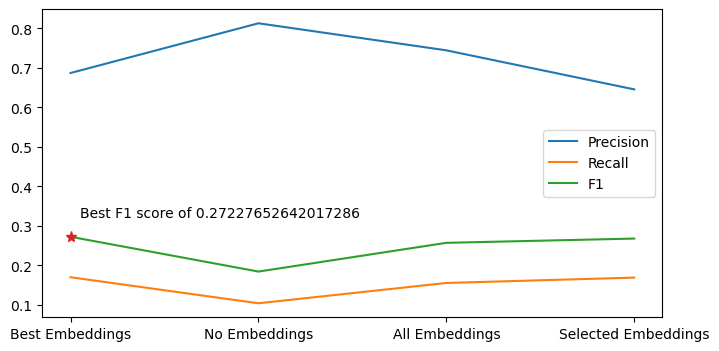

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
bm_no_embeddings_params = best_model_params.copy()
bm_no_embeddings_params["doc_with_ner"] = False
bm_no_embeddings_params["q_with_pos"] = False
bm_no_embeddings = ResultsHelper.get_matching_models(bm_no_embeddings_params, results)
bm_all_embeddings_params = best_model_params.copy()
bm_all_embeddings_params["q_with_ner"] = True
bm_all_embeddings_params["doc_with_pos"] = True
bm_all_embeddings_params["doc_with_tfidf"] = True
bm_all_embeddings_params["doc_with_wm"] = True
bm_all_embeddings = ResultsHelper.get_matching_models(bm_all_embeddings_params, results)
bm_selected_embeddings_params = best_model_params.copy()
bm_selected_embeddings_params["doc_with_tfidf"] = True
bm_selected_embeddings_params["doc_with_wm"] = True
bm_selected_embeddings_params["q_with_ner"] = True
bm_selected_embeddings_params["q_with_pos"] = False
bm_selected_embeddings = ResultsHelper.get_matching_models(bm_selected_embeddings_params, results)
ResultsHelper.plot_comparison_metrics_on_one_it([best_model, bm_no_embeddings, bm_all_embeddings, bm_selected_embeddings], it=80, train=False)
plt.legend()
plt.xticks([0,1,2,3], ["Best Embeddings", "No Embeddings", "All Embeddings", "Selected Embeddings"])
plt.show()

### 3.2. Attention Ablation Study

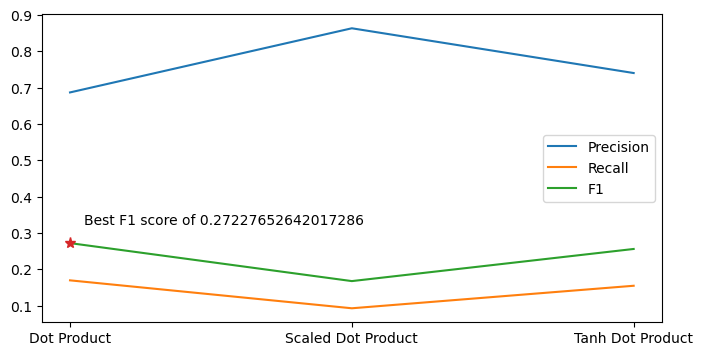

In [15]:
bm_scaled_dot_params = best_model_params.copy()
bm_scaled_dot_params["attention_type"] = "Scaled Dot Product"
bm_scaled_dot = ResultsHelper.get_matching_models(bm_scaled_dot_params, results)
bm_tanh_params = best_model_params.copy()
bm_tanh_params["attention_type"] = "Tanh"
bm_tanh = ResultsHelper.get_matching_models(bm_tanh_params, results)
plt.figure(figsize=(8,4))
ResultsHelper.plot_comparison_metrics_on_one_it([best_model, bm_scaled_dot, bm_tanh], it=80, train=False)
plt.legend()
plt.xticks([0,1, 2], ["Dot Product", "Scaled Dot Product", "Tanh Dot Product"])
plt.show()

### 3.3. Hyper Parameter Testing 

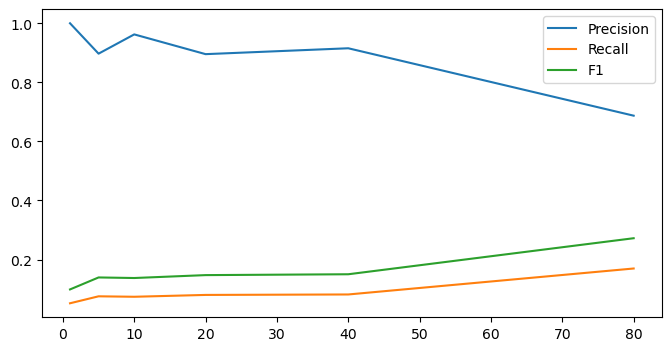

In [16]:
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_over_its(best_model, train=False)
plt.legend()
plt.show()